In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# ML libraries
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import math
import datetime as dtm

In [30]:
# LOAD DATA
df = pd.read_csv("KCB.csv", skipinitialspace=True)

# CLEANING DATA
# Reverse dataframe starting with earliest stock as first index
df = df.iloc[::-1]
# Drop reversed index and add default integer index
df = df.reset_index()
df = df.drop('index', axis=1)

# Convert date column to standard date format
for idx, row in df.iterrows():
    row.Date = dtm.datetime.strptime(row.Date, "%m/%d/%y")
    # row.Date = row.Date.strftime("%Y-%m-%d")
    df.at[idx,"Date"] = row.Date

# Get start date and end date
start = df['Date'].iloc[0].strftime("%Y-%m-%d")
end = df['Date'].iloc[len(df) - 1].strftime("%Y-%m-%d")

# Set Date as default index
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2005-04-08,5.77,5.77,5.77,5.77,1.296574e+05
2005-04-11,5.82,5.82,5.82,5.82,3.777439e+05
2005-04-12,5.82,5.82,5.82,5.82,1.027064e+06
2005-04-14,5.82,5.82,5.82,5.82,4.974514e+05
2005-04-15,5.87,5.87,5.87,5.87,4.055694e+05
...,...,...,...,...,...
2023-06-30,30.00,30.00,29.05,29.30,8.234000e+05
2023-07-03,29.05,29.45,29.05,29.30,1.640000e+05
2023-07-04,29.50,29.50,29.20,29.45,1.555900e+06


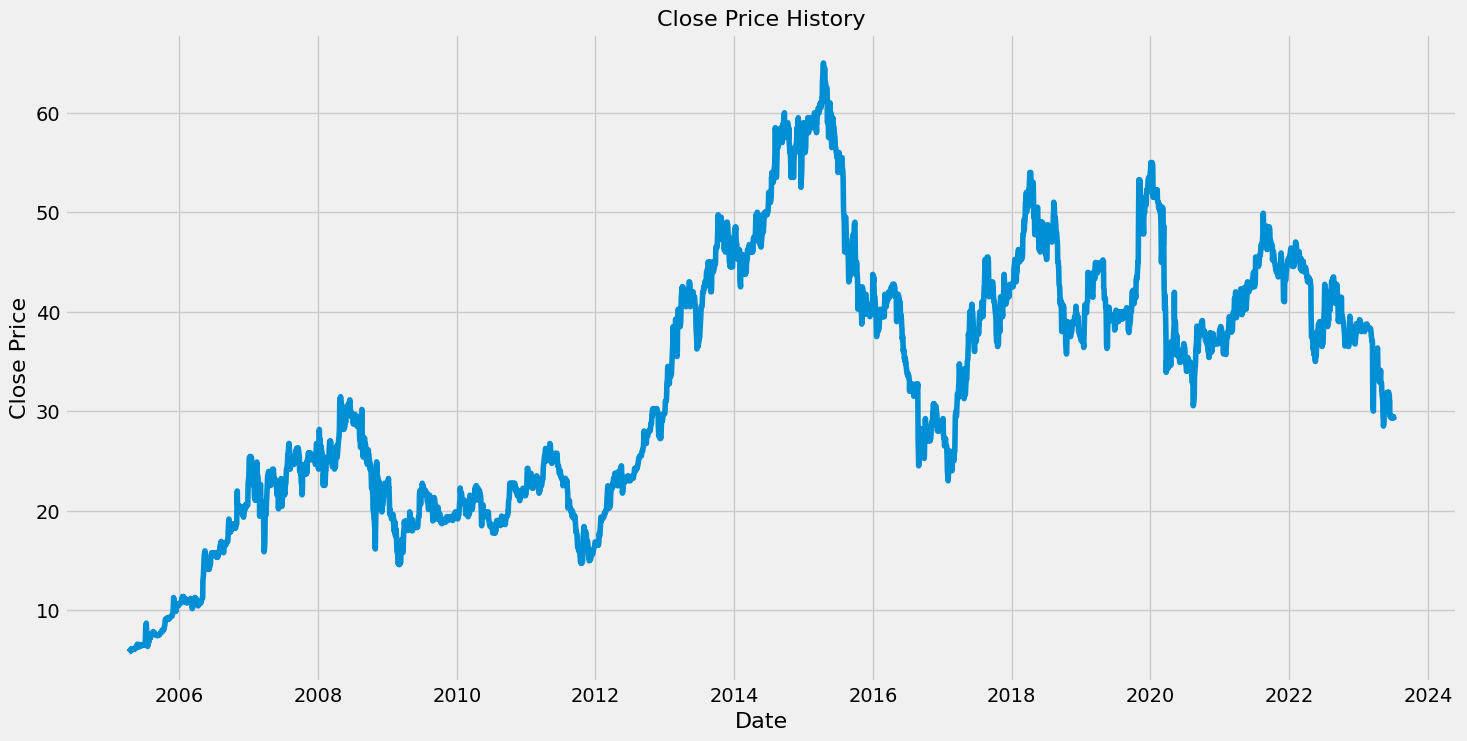

In [31]:
# Plot historical closing price
plt.figure(figsize=(16,8))
plt.title("Close Price History", fontsize=16)
plt.plot(df.Close)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.show()

In [32]:
# New dataframe with only close column
data = df.filter(["Close"])
data

,Close
Date,
2005-04-08,5.77
2005-04-11,5.82
2005-04-12,5.82
2005-04-14,5.82
2005-04-15,5.87
...,...
2023-06-30,29.30
2023-07-03,29.30
2023-07-04,29.45


In [33]:
# Convert the dataframe into a numpy array
dataset = data.values

In [34]:
# Get length of training and testing data
training_data_len = math.ceil(len(dataset) * 0.8)
test_data_len = len(dataset) - training_data_len
print("Training data length")
print(training_data_len)
print("Testing data length")
print(test_data_len)

Training data length
3640
Testing data length
910


In [35]:
# Scale down data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.        ],
       [0.00084417],
       [0.00084417],
       ...,
       [0.3997974 ],
       [0.3972649 ],
       [0.3947324 ]])

In [36]:
# Testing dataset
test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])

# Convert to numpy arrays
x_test = np.array(x_test)

In [37]:
# Reshape to 3D format
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(910, 60, 1)

In [38]:
# Load Saved Model
from keras.models import load_model
model = load_model("ke_lstm_model3")

In [39]:
# Get the models predicted values
predictions = model.predict(x_test)
# Scale down data
predictions = scaler.inverse_transform(predictions)

29/29 [==============================] - 0s 5ms/step


In [40]:
# Evaluate Model
# Get RMSE - root mean square error
# The closer the number to zero, the closer the predicted values to original values,
#  the better it was predicting 
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.4049740575434088

/var/folders/4f/xy4jvtjs1qg16v7xbbpgsc840000gn/T/ipykernel_61260/1099830945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


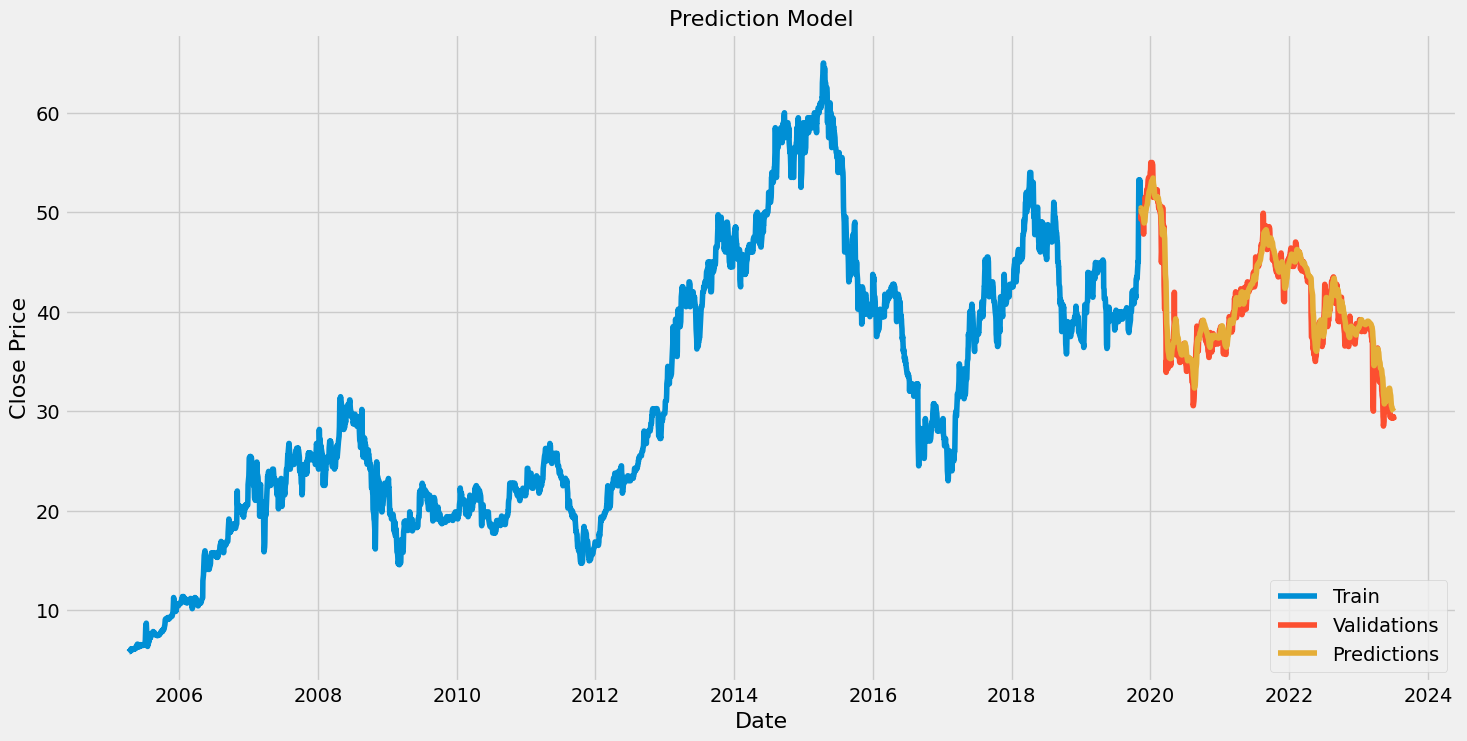

In [41]:
# Plot data
train = data[0: training_data_len] # from zero
valid = data[training_data_len:] # validation data
valid["Predictions"] = predictions

# Visualise data
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(train.Close)
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Validations", "Predictions"], loc="lower right")
plt.show()

In [42]:
# Show valid and predicted
valid

,Close,Predictions
Date,,
2019-11-11,49.75,50.379536
2019-11-12,49.30,50.431477
2019-11-13,49.55,50.308945
2019-11-14,49.90,50.136566
2019-11-15,50.25,49.990520
...,...,...
2023-06-30,29.30,30.119143
2023-07-03,29.30,30.063835
2023-07-04,29.45,30.016796


In [49]:
# Predict for the next n_days => n_days can be 10, 20, 30, 60, 100 days e.t.c
n_days = 10
# Create new dataframe
new_df = df.filter(["Close"])

# Combined dataframe: Contains original close prices and predicted prices
combined = new_df

data = {
    "Date": [],
    "Close": []
}
next_n_days = pd.DataFrame(data)
next_n_days.set_index('Date', inplace=True)

last_day = dtm.datetime.strptime(end, "%Y-%m-%d")
# last_day = last_day - dtm.timedelta(days=1)
last_day = last_day.strftime("%Y-%m-%d")
last_day = dtm.datetime.strptime(last_day, "%Y-%m-%d")

for i in range(n_days):
    # Get the last 100 days closing price and convert dataframe to an array
    last_n_days = combined[-100:].values
    # Scale down data
    last_n_days_scaled = scaler.transform(last_n_days)
    X_test = []
    X_test.append(last_n_days_scaled)
    # Convert to numpy arrays
    X_test = np.array(X_test)
    # Reshape to 3D format
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    # Predicted price
    pred_price = model.predict(X_test)
    # Scale up
    pred_price = scaler.inverse_transform(pred_price)
    
    #. Update dataframe with predicted value
    tomorrow = last_day + dtm.timedelta(days=1)
    # tomorrow = tomorrow.strftime("%Y-%m-%d")
    new_row = {
        "Date": [tomorrow],
        "Close": [pred_price[0].tolist()[0]]
    }
    last_day = tomorrow
    # last_day = dtm.datetime.strptime(last_day, "%Y-%m-%d")
    
    next_day = pd.DataFrame(new_row)
    next_day.set_index('Date', inplace=True)
    next_n_days = pd.concat([next_n_days, next_day])
    combined = pd.concat([combined, next_day])

1/1 [==============================] - 0s 12ms/step


In [50]:
new_df

,Close
Date,
2005-04-08,5.77
2005-04-11,5.82
2005-04-12,5.82
2005-04-14,5.82
2005-04-15,5.87
...,...
2023-06-30,29.30
2023-07-03,29.30
2023-07-04,29.45


In [51]:
next_n_days

,Close
Date,
2023-07-07,29.931269
2023-07-08,29.965712
2023-07-09,30.036856
2023-07-10,30.127619
2023-07-11,30.228630
2023-07-12,30.334820
2023-07-13,30.443497
2023-07-14,30.553238
2023-07-15,30.663334


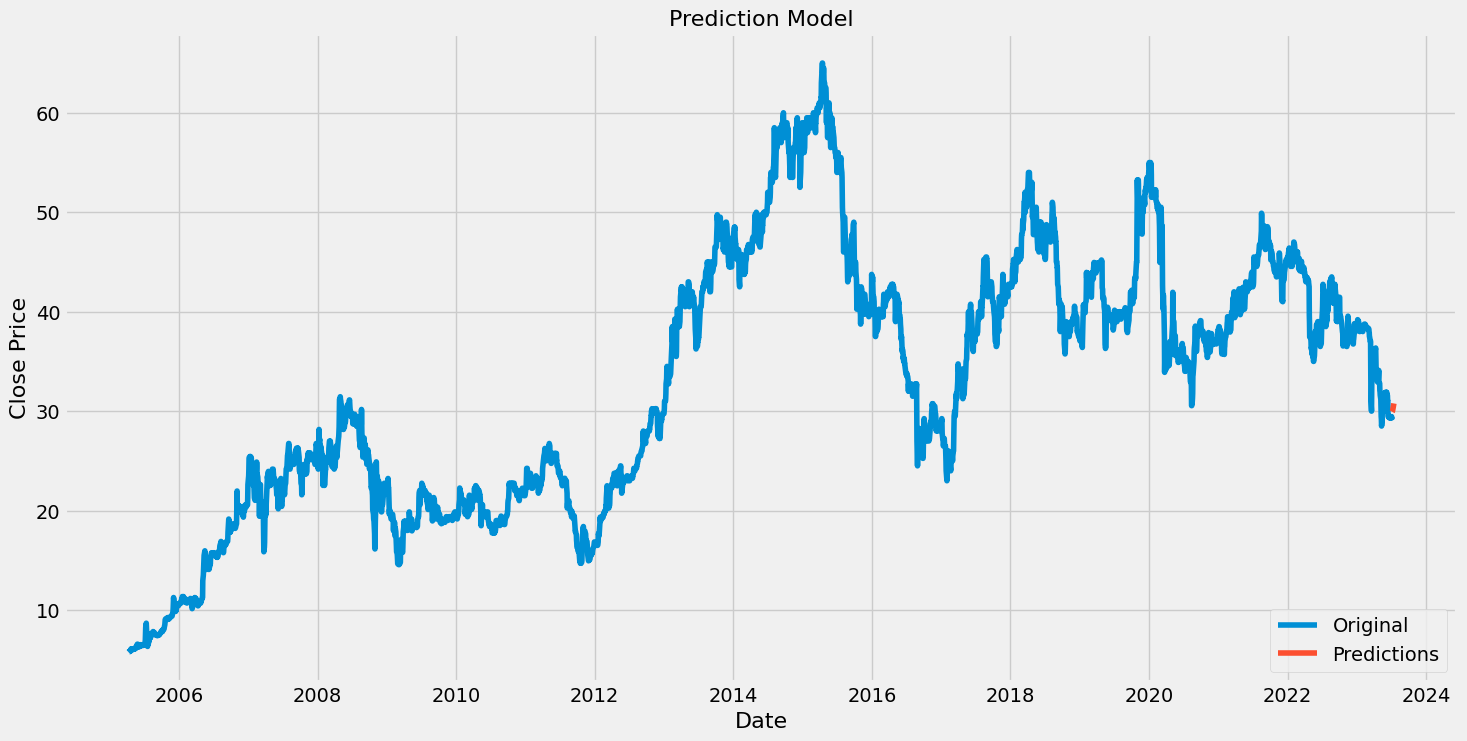

In [52]:
# Visualise data
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(new_df.Close)
plt.plot(next_n_days.Close)
plt.legend(["Original", "Predictions"], loc="lower right")
plt.show()

In [53]:
# Show previous 3 months plus n_days (10, 30, 60 e.t.c) predictions 
prev_days = 90;
prev_n_days = new_df[-prev_days:]
prev_n_days.tail()

,Close
Date,
2023-06-30,29.30
2023-07-03,29.30
2023-07-04,29.45
2023-07-05,29.30
2023-07-06,29.15


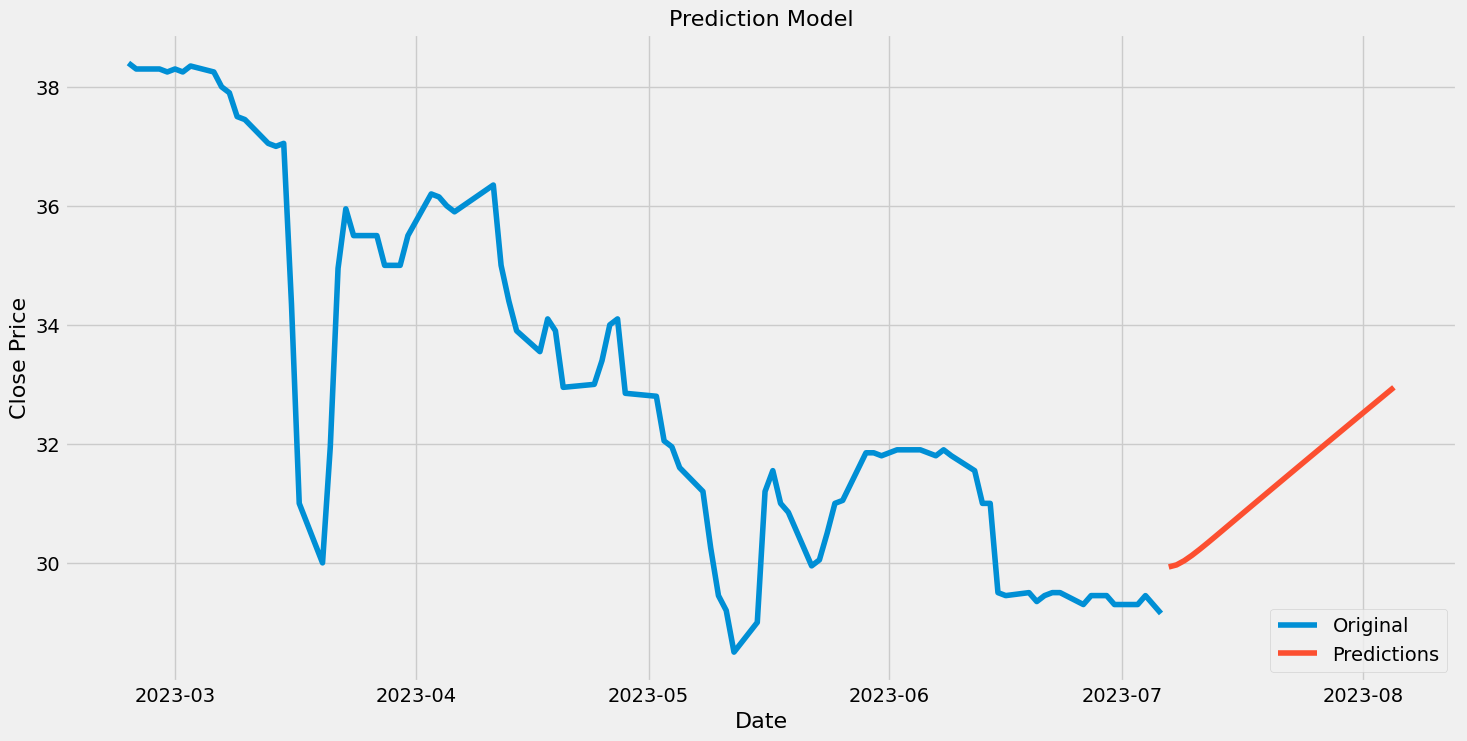

In [48]:
# Visualise data for previous 3 months
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(prev_n_days.Close)
plt.plot(next_n_days.Close)
plt.legend(["Original", "Predictions"], loc="lower right")
plt.show()